In [2]:
! ls ../

README.md	  data				    parsed_mappings.zip
analysis	  data.zip			    pmc_full_texts
assets		  dataall_uncategorized_pmids.json  preprocessing
caseolap	  kg_analysis			    requirements.txt
caseolap_lift.py  output.zip			    scratch
config		  parameters.txt		    text_mining
config.zip	  parsed_mappings		    utils


In [1]:
import requests as req
import json
import xml.etree.ElementTree as ET
import itertools
import os
import argparse
import sys
sys.path.append('..')
from utils.biomedkg_utils import switch_dictset_to_dictlist
from elasticsearch import Elasticsearch
from multiprocessing import cpu_count, Process

In [192]:
def map_disease_mesh_name_to_id(mesh_desc_file = '../data/MeSH/desc2022.xml', 
                                output_folder='../parsed_mappings/MeSH'):
    '''
    FUNCTION:
    - Map the disease MeSH names/terms to the
      MeSH IDs.
    '''
    print('Mapping MeSH disease names to IDs')
    tree = ET.parse(mesh_desc_file)
    root = tree.getroot()   
    
    name2id = dict()

    for ele in root:
        try:
            # MeSH Tree Number
            tree_numbers = ele.find('TreeNumberList').findall('TreeNumber')

            # If Tree is a disease
            for tree_number in tree_numbers:
                if tree_number.text.startswith(('C','F03')):
                    tree_number = tree_number.text

                    # ID to Name
                    try:
                        ID = ele.find('DescriptorUI').text
                        name = ele.find('DescriptorName').find('String').text
                        name2id.setdefault(name,set()).add(ID)
                    except:
                        pass
        except:
            continue        

    name2id = switch_dictset_to_dictlist(name2id)
    json.dump(name2id, open(os.path.join(output_folder,'name2id.json'),'w'))

In [193]:
def map_categories2terms(output_folder,
                         meshterms_per_cat_file='../parsed_mappings/MeSH/meshterms_per_cat.json',
                         category_names_file='../config/textcube_config.json'):
    '''
    FUNCTION:
    - Map disease categories -> MeSH terms
    '''
    print('Mapping disease categories to their terms and subcategory terms')
    terms_lol = json.load(open(meshterms_per_cat_file, 'r'))
    category_names = json.load(open(category_names_file, 'r'))
    category2terms = dict()
    for category_name, term_list in zip(category_names, terms_lol):
        category2terms[category_name] = term_list

    json.dump(category2terms,
              open(os.path.join(output_folder, 'category2terms.json'), 'w'))

    return category2terms

In [194]:
def get_mesh_synonyms_api(category2terms, name2id,
                          output_folder='../parsed_mappings/MeSH/'):
    '''
    FUNCTION:
    - Get MeSH synonyms via API
    '''
    category2synonyms = dict()
    total_categories = len(category2terms)
    for category_num, (category, terms) in enumerate(category2terms.items()):
        print(str(category_num) + '/' + str(total_categories), end='\r')

        # Terms in category
        for term in terms:

            mesh_id = name2id[term]
            assert len(mesh_id) == 1
            r_string = 'https://id.nlm.nih.gov/mesh/lookup/details?descriptor=' + mesh_id[0]
            r = req.get(r_string).json()

            # Add term synonyms to the category
            for entry in r['terms']:
                synonym = entry['label']
                category2synonyms.setdefault(category, set()).add(synonym)

    category2synonyms = switch_dictset_to_dictlist(category2synonyms)
    json.dump(category2synonyms,
              open(os.path.join(output_folder, 'category2synonyms.json'), 'w'))

    return category2synonyms

In [195]:
def permute_mesh_synonyms(mesh_synonyms):
    '''
    FUNCTION:
    - Permute MeSH synonyms

    PARAMS:
    - mesh_synonyms: list of mesh synonyms
    '''

    temp_mesh_synonyms = list()
    for mesh_synonym in mesh_synonyms:
        if ',' in mesh_synonym:
            mesh_synonym = mesh_synonym.split(', ')
            mesh_synonym_permuted = [' '.join(list(permuted_synonym)) for permuted_synonym in
                                     list(itertools.permutations(mesh_synonym))]
            temp_mesh_synonyms += mesh_synonym_permuted
        else:
            temp_mesh_synonyms.append(mesh_synonym)

    return temp_mesh_synonyms

In [196]:
def map_category_to_permuted_mesh_synonyms(category2synonyms,
                                           output_folder='../parsed_mappings/MeSH/'):
    '''
    FUNCTION:
    - permute the MeSH Synonyms because sometimes they're
      written weirdly with commas (e.g., Order, Messed, Up, Is;
      Messed, Order, Up)

    PARAMS:
    - category2synonyms: category -> MeSH synonyms mapping
    '''
    print('Mapping disease categories to permuted MeSH synonyms')

    # Permuted synonym->category dictionary
    category2permuted_synonyms, permuted_synonyms2category = dict(), dict()
    for category, synonyms in category2synonyms.items():
        synonyms = permute_mesh_synonyms(synonyms)
        for synonym in synonyms:
            category2permuted_synonyms.setdefault(category, set()).add(synonym)
            permuted_synonyms2category.setdefault(synonym, set()).add(category)

    category2permuted_synonyms = switch_dictset_to_dictlist(category2permuted_synonyms)
    permuted_synonyms2category = switch_dictset_to_dictlist(permuted_synonyms2category)

    json.dump(category2permuted_synonyms,
              open(os.path.join(output_folder, 'category2permuted_synonyms.json'), 'w'))
    json.dump(permuted_synonyms2category,
              open(os.path.join(output_folder, 'permuted_synonyms2category.json'), 'w'))

    return category2permuted_synonyms, permuted_synonyms2category

In [7]:
def get_all_uncategorized_pmids(index_name):
    '''
    FUNCTION:
    - Get the PMIDs of all the PubMed articles that
      don't have MeSH labels.
    - Purpose: For applying to unlabeled PubMed articles

    PARAMS:
    - index_name: The name of the ElasticSearch index
      where all the PubMed articles are indexed/stored
    '''

    es = Elasticsearch()
    relevant_uncategorized_pmids = set()
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):

        # Publication's MeSH (if any)
        unlabeled = (len(entry['MeSH']) == 0)

        # Save PMIDs of unlabeled documents
        if unlabeled:
            relevant_uncategorized_pmids.add(entry['pmid'])

            # Print progress
            if num_pmids % 10000 == 0:
                print(str(num_pmids) + ' PMIDs processed', end='\r')

    return list(relevant_uncategorized_pmids)

In [248]:
def get_document_text(entry):
    '''
    FUNCTION: 
    - Get the full text of the PubMed publication

    PARAMS: 
    - entry (dict): parsed indexed publication 
    '''

    # Title
    title = entry['_source']['title']
    if type(title) != str:
        title = ''
    title.replace('\n', ' ').replace('\t', ' ').replace('   ', ' ')

    # Abstract
    abstract = entry['_source']['abstract']
    if type(abstract) != str:
        abstract = ''
    abstract.replace('\n', ' ').replace('\t', ' ').replace('   ', ' ')

    return abstract, title

In [246]:
def ds_label_matching(batch_id, relevant_pmid_batch,
                      index_name, index_type, 
                      label_unlabeled_only,
                      label_labeled_only,
                      label_all,
                      filter_list, 
                      stop_at_this_many_pmids,
                      run, test,
                      output_folder):
    '''
    FUNCTION:
    - Using MeSH term synonyms, label a document with a MeSH term if the 
      lowercased term matches exactly within the text.
    
    PARAMS:
    - relevant_pmid_batch: PMIDs to look for in this batch
    - temp_outfile: temporary output file of PMID | MeSH Term
    '''
    es = Elasticsearch()
    if run:
        rot = 'run'
    elif test:
        rot = 'test'
    else:
        raise Except('Did not specify if running or testing')

    temp_outfile = os.path.join(output_folder, rot+'_temp_labeling'+str(batch_id)+'.txt')
    procs = cpu_count()
    category2permuted_synonyms = json.load(open(os.path.join(output_folder,'category2permuted_synonyms.json'),'r'))

    with open(temp_outfile,'w') as fout, \
    open(temp_outfile[:-4]+'synonym'+'.txt','w') as fout1:

        # Get PubMed article's text
        for num_pmids, pmid in enumerate(relevant_pmid_batch):
            entry = es.get(id = pmid, index = index_name, doc_type = index_type)

            # Print progress and break early
            if batch_id == 1 and num_pmids % 1000 == 0:
                print(str(num_pmids)+' PMIDs processed in one of the batches',\
                      end='\r')
            if num_pmids > stop_at_this_many_pmids/procs:
                break


            # Determine which publications to find labels for
            labeled_meshes = entry['_source']['MeSH']
            labeled = len(labeled_meshes) > 0
            unlabeled = len(labeled_meshes) == 0
            if label_labeled_only and labeled:
                pass
            elif label_unlabeled_only and unlabeled:
                pass
            elif label_all:
                pass
            else:
                continue
            
                        
            # Publication's text (title, abstract, full text if provided)
            abstract, title = get_document_text(entry)
            document_text = title + ' ' + abstract
            title = ' '+title+' '
            title = title.replace(',',' ')
            title = title.replace(':',' ')
            
            # Only consider documents that have certain broader key words
            # E.g., for cardiovascular disease publications, only look 
            # at publications that say "heart" or "cardiac" 
            #dont_label = True
            #for filter_word in filter_words:
            #    if filter_word in document_text.lower():
            #        dont_label = False
            #        break
            #if dont_label:
            #    continue
              
            #print(dont_label, 'dont_label')
            
            #fout.write(title+' | '+'ignore'+'\n')
            
            # Check if MeSH synonym is in the text
            for category, synonyms in category2permuted_synonyms.copy().items():
                found_syns = set()
                one_syn_in_title = False
                                                    
                # Each synonym in a set category
                for synonym in synonyms:

                    # Synonym in title
                    if ' '+synonym.lower()+' ' in title.lower():
                        one_syn_in_title = True
                        found_syns.add(synonym)
                        #continue
                        
                    # Synonym in abstract
                    
                    if synonym.lower() in abstract.lower():
                        add = True

                        # If similar synonym hasn't been counted already
                        for found_syn in found_syns:
                            fsyn = found_syn.lower().replace('\'','')
                            syn = synonym.lower()
                            if fsyn in syn or syn in fsyn:
                                add = False
                                break
                        if add:
                            found_syns.add(synonym)
                        
                    # Categorize text with 1+ synonym per category in the text
                    # (This could be modified to include confidence levels for
                    #  how many synonyms were found, remove break then)
                    if one_syn_in_title or len(found_syns) > 1:
                        #print(pmid, category, found_syns)
                        fout.write(pmid+'|'+category+'\n')
                        fout1.write(pmid+'|'+synonym+'\n')
                        break
                        
        try:
            print(str(num_pmids)+' PMIDs processed in one of the batches')
        except:
            # Not enough PMIDs to require doing all the batches
            pass

In [245]:
def multiprocess_ds_label_matching(pmids, index_name, index_type, 
                                   label_unlabeled_only,
                                   label_labeled_only,
                                   label_all,
                                   filter_list,
                                   the_function,
                                   stop_at_this_many_pmids,
                                   run = False,
                                   test = False,
                                   output_folder='../parsed_mappings/MeSH/'):
    '''
    FUNCTION:
    - This takes a list of strings and splits it into input
      for separate processes. The processes then output 
      their results to temp files which are then merged. 
    
    PARARMS:
    - pmids: the list to be split into input for 
      a multiprocessing function
    - the_function: the function that will use the list
      as input for multiprocessing
    '''    
    # How many processors can be used
    procs = cpu_count() if len(pmids) > cpu_count() else len(pmids)

    # List of batches for multiprocessing
    batches = [[] for i in range(procs)]   

    # Length of input list 
    tot = len(pmids)

    # Create batches and send to multiprocessing
    for i, item in enumerate(pmids):

        # Add synonym to a batch
        b_id = i%procs
        batches[b_id].append(item)

    # Create a list of jobs 
    print("Running jobs...")
    jobs = []
    for b_id, batch in enumerate(batches):
        jobs.append(Process(target = the_function,
                            args = [b_id, batch, 
                                    index_name, index_type, 
                                    label_unlabeled_only,
                                    label_labeled_only,
                                    label_all,
                                    filter_list,
                                    stop_at_this_many_pmids, 
                                    run, test, output_folder]))

    # Run the jobs
    for j in jobs: j.start()
    for j in jobs: j.join()
    print('Done!')    

In [197]:
def merge_pmid2new_mesh_labels(run=False, test=False, output_folder = '../parsed_mappings/MeSH/'):
    '''
    FUNCTION:
    - Merges the separate files containing PMID|category_name
      for the imputed category_name labels.
    '''
    
    pmid2imputed_meshsynonym, pmid2imputed_category = dict(), dict()
    procs = cpu_count()
    if run:
        rot = 'run'
    elif test:
        rot = 'test'

    for batch_id in range(procs):
        ''' PMID - MeSH Category '''
        temp_outfile = os.path.join(output_folder, rot+'_temp_labeling'+str(batch_id)+'.txt')
        with open(temp_outfile) as fin:
            for line in fin:
                line = line.split('|')

                # PMID, MeSH
                assert len(line) == 2
                pmid = line[0]
                mesh = line[1].strip()

                # PMID->MeSH
                pmid2imputed_category.setdefault(pmid, set()).add(mesh)
                
        ''' PMID - MeSH Synonym '''
        with open(temp_outfile[:-4]+'synonym'+'.txt') as fin1:
            for line in fin1:
                line = line.split('|')

                # PMID, MeSH
                assert len(line) == 2
                pmid = line[0]
                mesh = line[1].strip()

                # PMID->MeSH
                pmid2imputed_meshsynonym.setdefault(pmid, set()).add(mesh)                
                
    pmid2imputed_category = switch_dictset_to_dictlist(pmid2imputed_category)
    pmid2imputed_meshsynonym = switch_dictset_to_dictlist(pmid2imputed_meshsynonym)
    print(len(pmid2imputed_category), 'PMIDs with imputed labels')

    # Export PMID-Category mappings to dictionaries
    json.dump(pmid2imputed_category, 
              open(os.path.join(output_folder, 'pmid2imputed_category.json'), 'w'))
    json.dump(pmid2imputed_meshsynonym,
              open(os.path.join(output_folder, 'pmid2imputed_mesh_synonym.json'), 'w'))
    
    return pmid2imputed_category, pmid2imputed_meshsynonym

In [198]:
def index_imputed_mesh_categories(index_name, index_type):    
    '''
    FUNCTION:
    - index the imputed MeSH categories as MeSH terms
      in the ElasticSearch index
    
    PARAMS:
    - index_name: Name of the ElasticSearch index
    - index_type: Type name of the ElastichSearch index
    '''
    
    es = Elasticsearch()
    for pmid, imputed_category in pmid2imputed_category.items():
        
        # Get current MeSH terms
        entry = es.get(id = pmid, 
                       index = index_name, 
                       doc_type = index_type)
        mesh_terms = entry['_source']['MeSH']
        mesh_terms += imputed_category
        mesh_terms = list(set(mesh_terms))
        
        # Update each publication's index
        es.update(index = index_name, 
                  id = pmid,
                  doc_type = index_type,
                  doc = {'MeSH': mesh_terms})

In [199]:
def update_textcube_files(data_folder='../data/',
                          config_folder='../config/',
                          parsed_mapping_folder='../parsed_mappings'):
    '''
    FUNCTION:
    - Add category names to the considered MeSH Terms
    - Add pmid-category to pmid2category mapping files
    '''
    meshterms_per_cat = json.load(open(os.path.join(mapping_folder, 'MeSH/meshterms_per_cat.json'), 'r'))
    meshterms_per_cat = [set(meshlist) for meshlist in meshterms_per_cat]

    category_names = json.load(open(os.path.join(config_folder, 'textcube_config.json'), 'r'))

    for i in range(0, len(category_names)):
        meshterms_per_cat[i].add(category_names[i])
    meshterms_per_cat = [list(meshlist) for meshlist in meshterms_per_cat]
    json.dump(meshterms_per_cat, open(os.path.join(mapping_folder, 'MeSH/meshterms_per_cat.json'), 'w'))

    textcube_pmid2category = json.load(open(os.path.join(data_folder, 'textcube_pmid2category.json'), 'r'))
    textcube_category2pmid = json.load(open(os.path.join(data_folder, 'textcube_category2pmid.json'), 'r'))

    ''' Update textcube_category2pmid '''
    category_names = json.load(open(os.path.join(config_folder, 'textcube_config.json'), 'r'))
    category_name2num = {name: num for num, name in enumerate(category_names)}

    for pmid, imputed_categories in pmid2imputed_category.items():
        for imputed_category in imputed_categories:
            cat_num = category_name2num[imputed_category]
            textcube_category2pmid[cat_num].append(pmid)

    for i in range(0, len(textcube_category2pmid)):
        textcube_category2pmid[i] = list(set(textcube_category2pmid[i]))

    ''' Update textcube_pmid2category '''
    new_textcube_pmid2category = list()
    for cat_num, pmid_list in enumerate(textcube_category2pmid):
        for pmid in pmid_list:
            new_textcube_pmid2category.append([pmid, cat_num])

    json.dump(new_textcube_pmid2category, open(os.path.join(data_folder, 'textcube_pmid2category.json'), 'w'))
    json.dump(textcube_category2pmid, open(os.path.join(data_folder, 'textcube_category2pmid.json'), 'w'))

In [12]:
def get_all_categorized_pmids(index_name, outpath):
    '''
    FUNCTION:
    - Get the PMIDs of all the PubMed articles that
      don't have MeSH labels.
    - Purpose: For applying to unlabeled PubMed articles

    PARAMS:
    - index_name: The name of the ElasticSearch index
      where all the PubMed articles are indexed/stored
    - outpath: Where the categorized PMIDs will go.
    '''

    es = Elasticsearch()
    relevant_categorized_pmids = set()
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):

        # Publication's MeSH (if any)
        labeled = (len(entry['MeSH']) > 0)

        # Save PMIDs of unlabeled documents
        if labeled:
            relevant_categorized_pmids.add(entry['pmid'])

            # Print progress
            if num_pmids % 10000 == 0:
                print(str(num_pmids) + ' PMIDs processed', end='\r')

    relevant_categorized_pmids = list(relevant_categorized_pmids)
    json.dump(relevant_categorized_pmids, open(outpath + 'relevant_categorized_pmids.json', 'w'))

In [13]:
def get_groundtruth_pmid2categories(relevant_pmid_batch, index_name, 
                                    index_type, permuted_synonyms2category):
    '''
    FUNCTION:
    - This gets the ground truth labels, the MeSH-labeled PubMed documents
    
    PARAMS:
    - relevant_pmid_batch: This is the list of the PubMed IDs you want to 
      get ground truth for
    - index_name: name of the ElasticSearch index
    - index_type: name of the type of ElasticSearch index
    - permuted_synonyms2category: MeSH synonyms -> category
    '''
    pmids2real_categories = dict()
    es = Elasticsearch()
    total_pmids = len(relevant_pmid_batch)
    
    for num_pmids, pmid in enumerate(relevant_pmid_batch):
        if num_pmids % 10000 == 0:
            print('Getting real mappings' + str(num_pmids)+'/'+str(total_pmids),\
                  end='\r')
        entry = es.get(id = pmid, index = index_name, doc_type = index_type)
        pmids2real_categories[pmid] = set()
        
        # Publication's MeSH (if any)
        meshes = entry['_source']['MeSH'] 
        for mesh in meshes:
            try:
                categories = permuted_synonyms2category[mesh]
                for category in categories:
                    pmids2real_categories[pmid].add(category)
            except:
                pass
    pmids2real_categories = switch_dictset_to_dictlist(pmids2real_categories)
    return pmids2real_categories

In [14]:
def evaluate_label_imputation(pmid2imputed_category, pmid2real_categories):
    tp, fp, tn, fn = 0,0,0,0

    for pmid in pmid2real_categories:
        real_categories = pmid2real_categories[pmid]
        try: imputed_categories = pmid2imputed_category[pmid]
        except: imputed_categories = []
        real_and_imputed = real_categories + imputed_categories
        
        for category in real_and_imputed:
            #print(real_and_imputed)
            #print(real_categories)
            #print(imputed_categories)
            
            # Real = Yes
            if category in real_categories:
                
                # Real = Yes, Impute = Yes
                if category in imputed_categories:
                    tp += 1
                    
                # Real = Yes, Impute = No
                else:
                    fn += 1
                    
            elif category not in real_categories:
                
                # Real = No, Impute = Yes
                if category in imputed_categories:
                    fp += 1            

    print('Precision', round(tp/(tp+fp), 4))
    print('Recall', round(tp/(tp+fn), 4))
    print('TP', tp, 'FP', fp, 'FN',fn)

In [7]:
index_name = 'pubmed_lift'
index_type = 'pubmed_meta_lift'
undo_category_label_imputation = False
undo_last_category_label_imputation_only = False
label_imputation = True
run = True
test = False

if undo_category_label_imputation:
    label_imputation = False

if test == True:
    run = False
STOP_AT_THIS_MANY_PMIDS = 9999999999
filter_words = ['placeholder', 'these arent used anymore']

In [190]:
root_directory = '../'
data_folder=os.path.join(root_directory,"data")
config_folder=os.path.join(root_directory,"config")
mapping_folder=os.path.join(root_directory,"parsed_mappings")
output_folder = os.path.join(mapping_folder,'Output')

In [200]:
''' Label imputation '''
if label_imputation:

    '''Map MeSH ID - Name'''
    map_disease_mesh_name_to_id()


    meshterms_per_cat_file = os.path.join(mapping_folder,'MeSH/meshterms_per_cat.json')
    category_names_file = os.path.join(config_folder,'textcube_config.json')
              
    ''' Get MeSH Synonyms '''
    # Category - MeSH Terms
    category2main_terms = map_categories2terms(output_folder = output_folder,
                            meshterms_per_cat_file = meshterms_per_cat_file,
                            category_names_file = category_names_file)

    # Category - MeSH Terms' Synonyms (including terms)
    name2id = json.load(open(os.path.join(mapping_folder,'MeSH/meshterm-IS-meshid.json'),'r'))
    category2main_terms = json.load(open(os.path.join(mapping_folder, 'MeSH/category2terms.json')))
    try:  category2synonym_terms = json.load(open(os.path.join(mapping_folder,'MeSH/category2synonyms.json')))
    except: category2synonym_terms = get_mesh_synonyms_api(category2main_terms, name2id,output_folder=output_folder)
              
    # Category - permuted MeSH Terms' Synonyms
    temp1, temp2 =  map_category_to_permuted_mesh_synonyms(category2synonym_terms,output_folder=output_folder)
    category2permuted_synonyms = temp1
    permuted_synonyms2category = temp2


Mapping MeSH disease names to IDs
Mapping disease categories to their terms and subcategory terms
Mapping disease categories to permuted MeSH synonyms


In [33]:
if run:
    print('Running label imputation')
    '''Undo last label imputation'''
    try:
        pmid2imp_cat_path = os.path.join(mapping_folder,'MeSH/pmid2imputed_category.json')
        pmid2imputed_category = json.load(open(pmid2imp_cat_path))
        try:
            print('Removing the labels imputed last time')
            remove_imputed_category_mesh_terms_previous_li(index_name,
                                                           index_type,
                                                           pmid2imputed_category)
        except:
            raise Exception('Couldnt remove the last indexed imputed labels')
    except:
        print('No previous label imputation')
    '''Get relevant PMIDs'''
    try:
        relevant_pmids = json.load(open(data_folder+'all_uncategorized_pmids.json'))
    except:
        relevant_pmids = get_all_uncategorized_pmids(index_name)
    json.dump(relevant_pmids, open(os.path.join(data_folder,'all_uncategorized_pmids.json'),'w'))

    print(len(relevant_pmids), 'relevant pmids')
        
    ''' Impute missing MeSH labels '''
    # Impute PMIDs' Categories (i.e., Impute missing MeSH labels)
    multiprocess_ds_label_matching(pmids = relevant_pmids, 
                                   index_name = index_name, 
                                   index_type = index_type, 
                                   label_unlabeled_only = True,
                                   label_labeled_only = False,
                                   label_all = False,
                                   filter_list = filter_words,
                                   stop_at_this_many_pmids = STOP_AT_THIS_MANY_PMIDS,
                                   the_function = ds_label_matching,
                                   output_folder = output_folder,
                                   run = True)
    pmid2imputed_category, pmid2imputed_meshsynonym = merge_pmid2new_mesh_labels(run=True,output_folder=output_folder)
    # Index the imputed MeSH categories into their PMID entries
    index_imputed_mesh_categories(index_name=index_name, index_type=index_type)
    # Update the MeSH Terms Per Category file for the textcube
    update_textcube_files(data_folder=data_folder, config_folder=config_folder, parsed_mapping_folder=mapping_folder)

Running label imputation
Removing the labels imputed last time
No previous label imputation
5186823 relevant pmids
Running jobs...
648352 PMIDs processed in one of the batches
648352 PMIDs processed in one of the batches
648351 PMIDs processed in one of the batches
648352 PMIDs processed in one of the batches
648352 PMIDs processed in one of the batches
648352 PMIDs processed in one of the batches
648352 PMIDs processed in one of the batches
648352 PMIDs processed in one of the batches
Done!
13 PMIDs with imputed labels


AuthorizationException: AuthorizationException(403, 'cluster_block_exception', 'blocked by: [FORBIDDEN/12/index read-only / allow delete (api)];')

In [ ]:
if test:
    print('Testing label imputation')
    
    '''Get relevant PMIDs'''
    # Ground truth: PMIDs in your study already labeled by NIH with MeSH terms
    #relevant_pmids = json.load(open('../caseolap/data/pmids.json'))
    try:
        relevant_pmids = json.load(open(data_folder+'/relevant_categorized_pmids.json'))
    except:
        relevant_pmids_path = data_folder+'/relevant_categorized_pmids.json'
        relevant_pmids = get_all_categorized_pmids('pubmed_lift', relevant_pmids_path)
        json.dump(relevant_pmids, open(relevant_pmids_path, 'w'))
    ''' Impute missing MeSH labels '''
    # Impute PMIDs' Categories (i.e., Impute missing MeSH labels)
    multiprocess_ds_label_matching(pmids = relevant_pmids, 
                                   index_name = index_name, 
                                   index_type = index_type, 
                                   label_unlabeled_only = False,
                                   label_labeled_only = True,
                                   label_all = False,
                                   filter_list = filter_words,
                                   stop_at_this_many_pmids = STOP_AT_THIS_MANY_PMIDS,
                                   the_function = ds_label_matching,
                                   test = True)
    pmid2imputed_category, pmid2imputed_meshsynonym = merge_pmid2new_mesh_labels(test=True)
    # PMID - Ground Truth Categories
    try:
        pmid2real_categories = json.load(open(output_folder+'/pmid2real_categories.json'))
    except:
        pmid2real_categories = ['']
    if len(pmid2real_categories) != STOP_AT_THIS_MANY_PMIDS:
        pmid2real_categories = get_groundtruth_pmid2categories(relevant_pmids, index_name, index_type, permuted_synonyms2category)
        json.dump(pmid2real_categories, open(output_folder+'/pmid2real_categories.json','w'))
    # Evaluate results on ground truth
    evaluate_label_imputation(pmid2imputed_category, pmid2real_categories)

In [3]:
import requests as req
import json
import xml.etree.ElementTree as ET
import itertools
import os
import argparse
import sys
sys.path.append('..')
from utils.biomedkg_utils import switch_dictset_to_dictlist
from elasticsearch import Elasticsearch
from multiprocessing import cpu_count, Process

In [10]:
def es_iterate_all_documents(es, index, pagesize=250, scroll_timeout="1m", **kwargs):
    """
    Helper to iterate ALL values from a single index
    Yields all the documents.
    Source: https://techoverflow.net/2019/05/07/elasticsearch-how-to-iterate-scroll-through-all-documents-in-index/
    """
    is_first = True
    while True:
        # Scroll next
        if is_first: # Initialize scroll
            result = es.search(index=index, scroll="1m", **kwargs, 
                               size = pagesize)
            is_first = False
        else:
            result = es.scroll(
                scroll_id = scroll_id,
                scroll = scroll_timeout)
        scroll_id = result["_scroll_id"]
        hits = result["hits"]["hits"]

        # Stop after no more docs
        if not hits:
            break
        
        # Yield each entry
        yield from (hit['_source'] for hit in hits)

def get_all_uncategorized_pmids(index_name):
    '''
    FUNCTION:
    - Get the PMIDs of all the PubMed articles that
      don't have MeSH labels.
    - Purpose: For applying to unlabeled PubMed articles

    PARAMS:
    - index_name: The name of the ElasticSearch index
      where all the PubMed articles are indexed/stored
    '''

    es = Elasticsearch()
    relevant_uncategorized_pmids = set()
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):

        # Publication's MeSH (if any)
        unlabeled = (len(entry['MeSH']) == 0)

        # Save PMIDs of unlabeled documents
        if unlabeled:
            relevant_uncategorized_pmids.add(entry['pmid'])

            # Print progress
            if num_pmids % 10000 == 0:
                print(str(num_pmids) + ' PMIDs processed', end='\r')
                if num_pmids > 50000:
                    break

    return list(relevant_uncategorized_pmids)

index_name = 'pubmed_lift'
temp = get_all_uncategorized_pmids(index_name)

In [9]:
len(temp)

29661

In [10]:
29661/170000

0.1744764705882353

In [ ]:
'''
TODO:
- run get_all_uncategorized -> PMID for unlabeled
- run get_all_categorized -> PMID for labeled
- use these to generate abstract & titles heatmap for overlap 

'''

In [15]:
def get_all_uncategorized_pmids(index_name):
    '''
    FUNCTION:
    - Get the PMIDs of all the PubMed articles that
      don't have MeSH labels.
    - Purpose: For applying to unlabeled PubMed articles

    PARAMS:
    - index_name: The name of the ElasticSearch index
      where all the PubMed articles are indexed/stored
    '''

    es = Elasticsearch()
    relevant_uncategorized_pmids = set()
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):

        has_full_text = (len(entry['full_text']) > 0)
        
        if has_full_text:
            return entry
        
        # Publication's MeSH (if any)
#         unlabeled = (len(entry['MeSH']) == 0)
#         return entry
        
#         # Save PMIDs of unlabeled documents
#         if unlabeled:
#             relevant_uncategorized_pmids.add(entry['pmid'])

#             # Print progress
#             if num_pmids % 10000 == 0:
#                 print(str(num_pmids) + ' PMIDs processed', end='\r')
#                 if num_pmids > 50000:
#                     break

#     return list(relevant_uncategorized_pmids)

index_name = 'pubmed_lift'
temp = get_all_uncategorized_pmids(index_name)

In [16]:
temp

{'pmid': '27649969',
 'title': 'Epac2-Rap1 Signaling Regulates Reactive Oxygen Species Production and Susceptibility to Cardiac Arrhythmias.',
 'abstract': 'In the heart, β\nInhibition of Epac2 signaling induced early afterdepolarization arrhythmias in ventricular myocytes. The underlying mechanism involved an increase in mitochondrial reactive oxygen species (ROS) and activation of the late sodium current (INa\nOur findings show for the first time that Rap1 acts as a negative regulator of mitochondrial ROS production in the heart and that impaired Epac2-Rap1 signaling causes arrhythmias due to ROS-dependent activation of INa\nEpac2-Rap1 signaling attenuates mitochondrial ROS production and reduces myocardial arrhythmia susceptibility. Antioxid. Redox Signal. 27, 117-132.',
 'full_text': "\n\t\t\t\n    \n\t\t\t\n\t\t\t\t\n      \n\t\t\t\tIntroduction\n\t\t\t\t\n      \n\t\t\t\t\n\t\t\t\t\tS\n\t\t\t\t\tympathetic control of\n\t\t\t\t\t the myocardium makes a major contribution to the in

In [19]:
def get_all_uncategorized_pmids(index_name):
    '''
    FUNCTION:
    - Get the PMIDs of all the PubMed articles that
      don't have MeSH labels.
    - Purpose: For applying to unlabeled PubMed articles

    PARAMS:
    - index_name: The name of the ElasticSearch index
      where all the PubMed articles are indexed/stored
    '''

    es = Elasticsearch()
    relevant_uncategorized_pmids = set()
    count = 0
    full_text_count = 0
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):

        count += 1
      
        has_full_text = (len(entry['full_text']) > 0)
                
        if has_full_text:
            full_text_count += 1
        
        
        # Print progress
        if num_pmids % 10000 == 0:
            print(str(num_pmids) + ' PMIDs processed' + ' (%d/%d)'%(full_text_count,count), end='\r')
        

    return count, full_text_count

        # Publication's MeSH (if any)
#         unlabeled = (len(entry['MeSH']) == 0)
#         return entry
        
#         # Save PMIDs of unlabeled documents
#         if unlabeled:
#             relevant_uncategorized_pmids.add(entry['pmid'])

#             # Print progress
#             if num_pmids % 10000 == 0:
#                 print(str(num_pmids) + ' PMIDs processed', end='\r')
#                 if num_pmids > 50000:
#                     break

#     return list(relevant_uncategorized_pmids)

index_name = 'pubmed_lift'
get_all_uncategorized_pmids(index_name)

(34383846, 58265)

In [22]:
def get_all_pmids(index_name):
    '''
    FUNCTION:
    - Get the PMIDs of all the PubMed articles

    PARAMS:
    - index_name: The name of the ElasticSearch index
      where all the PubMed articles are indexed/stored
    '''

    es = Elasticsearch()
    all_pmids = []
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):

        # Publication's MeSH (if any)
        # labeled = (len(entry['MeSH']) > 0)

        # Save PMIDs of documents
        all_pmids.append(entry['pmid'])

        # Print progress
        if num_pmids % 10000 == 0:
            print(str(num_pmids) + ' PMIDs processed', end='\r')

    all_pmids = list(set(all_pmids))
    # json.dump(relevant_categorized_pmids, open(outpath + 'relevant_categorized_pmids.json', 'w'))
    
    return all_pmids

In [23]:
all_doc_pmids = get_all_pmids(index_name)

In [16]:
def get_pmids(index_name):
    '''
    Get the PMIDs of the PubMed articles that have/don't have MeSH labels or full text
    '''

    es = Elasticsearch()
    uncategorized_pmids = list()
    categorized_pmids = list()
    uncate_text_pmids = list()
    cate_text_pmids = list()
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):
        
        # Publication's MeSH (if any)
        unlabeled = (len(entry['MeSH']) == 0)

        # Save PMIDs
        if unlabeled:
            uncategorized_pmids.append(entry['pmid'])
        else:
            categorized_pmids.append(entry['pmid'])
        
        # has full text or not
        has_full_text = (len(entry['full_text']) > 0)
        
        if has_full_text:
            if unlabeled:
                uncate_text_pmids.append(entry['pmid'])
            else:
                cate_text_pmids.append(entry['pmid'])

        # Print progress
        if num_pmids % 10000 == 0:
            print(str(num_pmids) + ' PMIDs processed', end='\r')

    return list(set(uncategorized_pmids)), list(set(categorized_pmids)), list(set(uncate_text_pmids)), list(set(cate_text_pmids))

In [17]:
uncate_pmids, cate_pmids, text_pmids = get_pmids(index_name)

KeyboardInterrupt: 

In [20]:
def get_groundtruth_pmid2categories(relevant_pmid_batch, index_name, 
                                    index_type, permuted_synonyms2category):
    '''
    FUNCTION:
    - This gets the ground truth labels, the MeSH-labeled PubMed documents
    
    PARAMS:
    - relevant_pmid_batch: This is the list of the PubMed IDs you want to 
      get ground truth for
    - index_name: name of the ElasticSearch index
    - index_type: name of the type of ElasticSearch index
    - permuted_synonyms2category: MeSH synonyms -> category
    '''
    pmids2real_categories = dict()
    es = Elasticsearch()
    total_pmids = len(relevant_pmid_batch)
    
    for num_pmids, pmid in enumerate(relevant_pmid_batch):
        if num_pmids % 10000 == 0:
            print('Getting real mappings' + str(num_pmids)+'/'+str(total_pmids),\
                  end='\r')
        entry = es.get(id = pmid, index = index_name, doc_type = index_type)
        pmids2real_categories[pmid] = list()
        
        # Publication's MeSH (if any)
        meshes = entry['_source']['MeSH'] 
        for mesh in meshes:
            try:
                categories = permuted_synonyms2category[mesh]
                pmids2real_categories[pmid] = list(set(pmids2real_categories[pmid] + categories))
            except:
                pass

    pmids2real_categories = switch_dictset_to_dictlist(pmids2real_categories)
    return pmids2real_categories

In [28]:
permuted_synonyms2category = json.load(open('../parsed_mappings/MeSH/permuted_synonyms2category.json'))

In [29]:
pmid2cate = get_groundtruth_pmid2categories(all_doc_pmids, index_name, index_type, permuted_synonyms2category)

In [48]:
import sys
# sys.path.append('/home/ubuntu/InternProjects/Joanne/caseolap_lift/data')

cat = open('/home/ubuntu/InternProjects/Joanne/caseolap_lift/data/relevant_categorized_pmids.json')
categorized_pmids = json.load(cat)

uncat = open('/home/ubuntu/InternProjects/Joanne/caseolap_lift/data/all_uncategorized_pmids.json')
uncategorized_pmids = json.load(uncat)

cat.close()
uncat.close()

In [49]:
pmids = categorized_pmids + uncategorized_pmids

In [95]:
len(pmids)

34440950

In [237]:
def generate_ctg2pmid(cat_pmids, uncat_pmids, all_pmids):
    '''
    generate a dictionary with categories as keys and pmids as values
    '''
    
    ctg2pmid = {'None': uncat_pmids}
    
    for num, key in enumerate(cat_pmids):
        
        # Print progress
        if num % 10000 == 0:
            print(str(num) + ' PMIDs processed', end='\r')
        
        if key in all_pmids:
            tags = all_pmids[key]
            if tags:
                for tag in tags:
                    if tag in ctg2pmid:
                        ctg2pmid[tag].append(key)
                    else:
                        ctg2pmid[tag] = [key]
    
    return ctg2pmid

In [302]:
len(cate_pmids)

29253534

In [335]:
len(uncate_pmids)

5130295

In [304]:
len(cate_pmids)+len(uncate_pmids)

34383829

In [306]:
len(pmid2cate)

34383846

In [309]:
only_cvd_pmid2cate = {k:v for k,v in pmid2cate.items() if len(v)>0}
cvd_pmids = set(only_cvd_pmid2cate.keys())
non_cvd_pmids = set(cate_pmids).difference(cvd_pmids)

In [311]:
len(only_cvd_pmid2cate)

967281

In [313]:
# These are the number of labeled or unlabled documents, which are not related to one of the CVDs
len(pmid2cate)-len(only_cvd_pmid2cate)

33416565

In [316]:
cvd_pmids = set(only_cvd_pmid2cate.keys())
non_cvd_pmids = set(cate_pmids).difference(cvd_pmids)


{'27112044',
 '29985861',
 '31542083',
 '32936422',
 '26773517',
 '15212098',
 '15026194',
 '31533607',
 '2234883',
 '4654979',
 '5105786',
 '10356387',
 '12450791',
 '31044303',
 '18767923',
 '23838946',
 '21664923',
 '4988786',
 '34536486',
 '14708437',
 '7337643',
 '21936022',
 '6283032',
 '27742685',
 '19124310',
 '6885336',
 '11731707',
 '4720604',
 '9240544',
 '15316989',
 '5575435',
 '9859947',
 '23557782',
 '33953396',
 '23778227',
 '19417464',
 '2491444',
 '5094950',
 '3548746',
 '24345571',
 '874031',
 '4289342',
 '18933104',
 '8419395',
 '672580',
 '20522117',
 '4349936',
 '21389106',
 '13437892',
 '2397590',
 '12075913',
 '3549025',
 '12991966',
 '28943563',
 '33961604',
 '12320589',
 '30099846',
 '24543214',
 '30191084',
 '27704717',
 '35684787',
 '21333035',
 '10843697',
 '17153192',
 '120045',
 '27625142',
 '20163956',
 '32236799',
 '5927485',
 '33757410',
 '24119845',
 '16562604',
 '6402976',
 '13318053',
 '28012907',
 '33992974',
 '1234822',
 '13181317',
 '1286268',
 '

In [321]:
# cvd_pmids = set(only_cvd_pmid2cate.keys())
# non_cvd_pmids = set(cate_pmids).difference(cvd_pmids)

print(len(set(uncate_pmids).intersection(cvd_pmids)))
print(len(set(uncate_pmids).intersection(non_cvd_pmids)))
print(len(cvd_pmids.intersection(non_cvd_pmids)))

0
0
0


In [323]:
print(len(uncate_pmids))
print(len(non_cvd_pmids))
print(len(cvd_pmids))
print(len(uncate_pmids)+len(non_cvd_pmids)+len(cvd_pmids))

5130295
28286253
967281
34383829


In [312]:
only_cvd_pmid2cate

{'10900171': ['OTH'],
 '19023153': ['CM'],
 '21131480': ['IHD', 'CM'],
 '30625100': ['CM'],
 '3413762': ['ARR', 'CCD'],
 '5701309': ['IHD'],
 '25760988': ['IHD'],
 '10325756': ['CHD'],
 '29466183': ['CM'],
 '7343368': ['IHD'],
 '3122317': ['IHD'],
 '34045667': ['CHD'],
 '18097070': ['IHD', 'CHD'],
 '20662236': ['IHD'],
 '282461': ['VD'],
 '22300785': ['CM'],
 '12613441': ['IHD'],
 '6233892': ['IHD'],
 '17200451': ['VD'],
 '23257536': ['ARR', 'CCD'],
 '10478813': ['IHD'],
 '12142190': ['CM'],
 '4468125': ['CHD'],
 '18609044': ['IHD'],
 '9609817': ['IHD'],
 '1618218': ['IHD'],
 '15794112': ['CM'],
 '2284717': ['IHD'],
 '10976155': ['ARR', 'CCD'],
 '4251819': ['OTH'],
 '5597558': ['IHD'],
 '28510240': ['ARR'],
 '22381430': ['ARR'],
 '2465472': ['IHD'],
 '31395251': ['IHD'],
 '21324629': ['ARR'],
 '11603072': ['IHD'],
 '1043104': ['IHD'],
 '28593660': ['CM'],
 '26056239': ['IHD'],
 '3917445': ['CM'],
 '1751150': ['OTH'],
 '3929730': ['ARR', 'CCD'],
 '14066053': ['ARR', 'CCD'],
 '30533038':

In [259]:
ctg2pmid = generate_ctg2pmid(cate_pmids, uncate_pmids, pmid2cate)

In [403]:
ctg2pmid_path = '../text_mining/ctg2pmid.json'
json.dump(ctg2pmid, open(ctg2pmid_path, 'w'))

In [142]:
def plot_num_of_publications(all_pmids):
    '''
    plot a bar plot of the number of publications of different categories
    '''
    
    # ctg = list(all_pmids.keys())
    ctg = order.copy()
    ctg.append('None')
    count = [len(all_pmids[val]) for val in ctg]
    
    fig = plt.figure(figsize = (10, 5))
    # c = ['#ceb78b', '#caa072', '#b68e6b', '#907659', '#945c37', '#66472d', '#463111', '#2c1504','#2e1f09']
    g = sns.barplot(x=ctg, y=count, log=True)
    
    for index, row in enumerate(count):
        g.text(index, row, row, color='black', ha='center')
    # plt.bar(ctg, count, color ='blue', width = 0.4)
    plt.xlabel("Categories", fontsize=15)
    plt.ylabel("Number of publications", fontsize=15)
    plt.title("Amount of publications per category", fontsize=15)
    plt.show()

In [120]:
c = order.copy()
c.append('None')

In [121]:
c

['CM', 'ARR', 'CHD', 'VD', 'IHD', 'CCD', 'VOO', 'OTH', 'None']

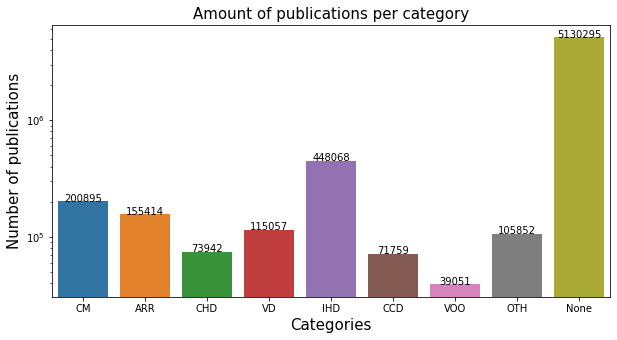

In [143]:
import matplotlib.pyplot as plt
plot_num_of_publications(ctg2pmid)

In [240]:
number_of_overlap = {}
for key in ctg2pmid:
    if key != 'None':
        number_of_overlap[key] = {}
        for key2 in ctg2pmid:
            if key2 != 'None':
                l1 = ctg2pmid[key]
                l2 = ctg2pmid[key2]
                number_of_overlap[key][key2] = len(set(l1).intersection(l2))

In [241]:
import pandas as pd
import seaborn as sns

matrix = pd.DataFrame(number_of_overlap).T.fillna(0)
# cols = matrix.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# matrix = matrix[cols]
# np.log(matrix)
matrix

,OTH,CM,IHD,ARR,CCD,CHD,VD,VOO
OTH,105852,8895,10466,7406,3335,1690,6739,1986
CM,8895,200895,38856,11175,5441,4946,8042,1824
IHD,10466,38856,448068,17036,8971,4015,9630,2626
ARR,7406,11175,17036,155414,71593,2077,5518,1332
CCD,3335,5441,8971,71593,71759,1593,2175,856
CHD,1690,4946,4015,2077,1593,73942,11182,4587
VD,6739,8042,9630,5518,2175,11182,115057,36260
VOO,1986,1824,2626,1332,856,4587,36260,39051


In [ ]:
def plot_overlap(all_pmid):
    number_of_overlap = {}
    for key in all_pmid:
        if key != 'None':
            number_of_overlap[key] = {}
            for key2 in all_pmid:
                if key2 != 'None':
                    l1 = all_pmid[key]
                    l2 = all_pmid[key2]
                    number_of_overlap[key][key2] = len(set(l1).intersection(l2))
                    
    matrix = pd.DataFrame(number_of_overlap).T.fillna(0)
    mat = np.tril(matrix) - np.diag(np.diag(matrix))
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, norm=LogNorm(), annot=matrix, mask=mat, fmt=".0f")

<AxesSubplot:>

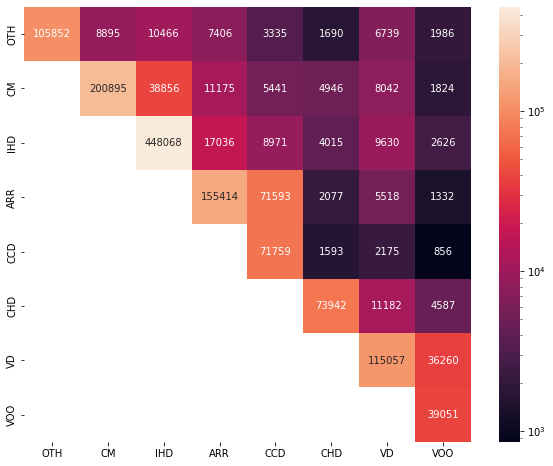

In [243]:
from matplotlib.colors import LogNorm
import numpy as np
                    
mat = np.tril(matrix) - np.diag(np.diag(matrix))
plt.figure(figsize=(10,8))
sns.heatmap(matrix, norm=LogNorm(), annot=matrix, mask=mat, fmt=".0f")

In [271]:
def plot_proportion(all_pmid):
    CVD = sum([len(all_pmid[key]) for key in all_pmid if key != 'None' and key != 'OTH'])
    non_CVD = len(all_pmid['OTH'])
    none = len(all_pmid['None'])
    
    features = ['None', 'Non-CVD', 'CVD']
    amount = [none, non_CVD, CVD]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(amount, labels=features, autopct='%1.1f%%')

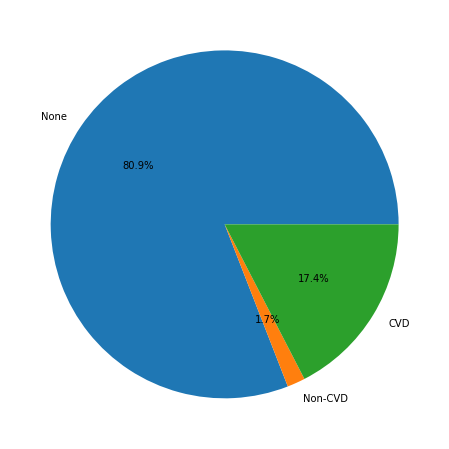

In [272]:
plot_proportion(ctg2pmid)

In [88]:
pmid2cat = '/home/ubuntu/InternProjects/Joanne/caseolap_lift/parsed_mappings/MeSH/pmid2real_categories.json'
f = open(pmid2cat)
data = json.load(f)
not_CVD_pmids = []
for key in categorized_pmids:
    if key not in data: 
        not_CVD_pmids.append(key)
f.close()

In [249]:
if run:
    print('Running label imputation')
    '''Undo last label imputation'''
    try:
        pmid2imp_cat_path = os.path.join(mapping_folder,'MeSH/pmid2imputed_category.json')
        pmid2imputed_category = json.load(open(pmid2imp_cat_path))
        try:
            print('Removing the labels imputed last time')
            remove_imputed_category_mesh_terms_previous_li(index_name,
                                                           index_type,
                                                           pmid2imputed_category)
        except:
            raise Exception('Couldnt remove the last indexed imputed labels')
    except:
        print('No previous label imputation')
    '''Get relevant PMIDs'''
    try:
        relevant_pmids = uncate_pmids
    except:
        relevant_pmids = get_all_uncategorized_pmids(index_name)
    json.dump(relevant_pmids, open(os.path.join(data_folder,'all_uncategorized_pmids.json'),'w'))

    print(len(relevant_pmids), 'relevant pmids')
        
    ''' Impute missing MeSH labels '''
    # Impute PMIDs' Categories (i.e., Impute missing MeSH labels)
    multiprocess_ds_label_matching(pmids = relevant_pmids, 
                                   index_name = index_name, 
                                   index_type = index_type, 
                                   label_unlabeled_only = True,
                                   label_labeled_only = False,
                                   label_all = False,
                                   filter_list = filter_words,
                                   stop_at_this_many_pmids = STOP_AT_THIS_MANY_PMIDS,
                                   the_function = ds_label_matching,
                                   output_folder = output_folder,
                                   run = True)
    pmid2imputed_category, pmid2imputed_meshsynonym = merge_pmid2new_mesh_labels(run=True,output_folder=output_folder)
    # Index the imputed MeSH categories into their PMID entries
    index_imputed_mesh_categories(index_name=index_name, index_type=index_type)
    # Update the MeSH Terms Per Category file for the textcube
    update_textcube_files(data_folder=data_folder, config_folder=config_folder, parsed_mapping_folder=mapping_folder)

Running label imputation
Removing the labels imputed last time
No previous label imputation
5130312 relevant pmids
Running jobs...
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
641288 PMIDs processed in one of the batches
Done!
17 PMIDs with imputed labels


AuthorizationException: AuthorizationException(403, 'cluster_block_exception', 'blocked by: [FORBIDDEN/12/index read-only / allow delete (api)];')

In [250]:
pmid2imputed_category

{'35615696': ['VD'],
 '34401699': ['ARR', 'CCD'],
 '29467831': ['ARR', 'CCD'],
 '27747715': ['ARR', 'CCD'],
 '16943976': ['ARR', 'CCD'],
 '28770754': ['ARR', 'CCD'],
 '19083349': ['ARR', 'CCD'],
 '18650979': ['ARR', 'CCD'],
 '28374333': ['ARR', 'CCD'],
 '27134440': ['ARR', 'CCD'],
 '29211605': ['CM'],
 '30555606': ['ARR', 'CCD'],
 '25147639': ['CM'],
 '20169139': ['ARR', 'CCD'],
 '32477709': ['ARR', 'CCD'],
 '30532877': ['ARR', 'CCD'],
 '18782505': ['CM']}

In [253]:
pmid2imputed_category.items()

dict_items([('35615696', ['VD']), ('34401699', ['ARR', 'CCD']), ('29467831', ['ARR', 'CCD']), ('27747715', ['ARR', 'CCD']), ('16943976', ['ARR', 'CCD']), ('28770754', ['ARR', 'CCD']), ('19083349', ['ARR', 'CCD']), ('18650979', ['ARR', 'CCD']), ('28374333', ['ARR', 'CCD']), ('27134440', ['ARR', 'CCD']), ('29211605', ['CM']), ('30555606', ['ARR', 'CCD']), ('25147639', ['CM']), ('20169139', ['ARR', 'CCD']), ('32477709', ['ARR', 'CCD']), ('30532877', ['ARR', 'CCD']), ('18782505', ['CM'])])

In [260]:
def update_ctg2pmid(all_pmid, imputed_cate):
    
    for key, cates in imputed_cate.items():
        for cate in cates:
            all_pmid[cate].append(key)
        all_pmid['None'].remove(key)
    
    return all_pmid

In [261]:
ctg2pmid = update_ctg2pmid(ctg2pmid, pmid2imputed_category)

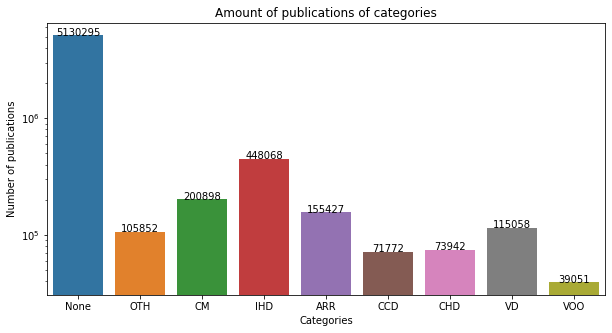

In [262]:
plot_num_of_publications(ctg2pmid)

## libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
import numpy as np

## Functions to create figures
1. heatmap of overlapping between categories
2. bar plot of number of publications of categories
3. venn diagram showing proportions of publications: unlabelled, CVDs, non-CVDs

In [3]:
order = ["CM", "ARR", "CHD", "VD", "IHD", "CCD", "VOO", "OTH"]

In [104]:
def plot_overlap(all_pmid):
    '''
    plot a heatmap to display the amount of overlap between each pair of categories
    '''
    
    number_of_overlap = {}
    for key in order:
        if key != 'None':
            number_of_overlap[key] = {}
            for key2 in order:
                if key2 != 'None':
                    l1 = all_pmid[key]
                    l2 = all_pmid[key2]
                    number_of_overlap[key][key2] = len(set(l1).intersection(l2))
                    
    matrix = pd.DataFrame(number_of_overlap).T.fillna(0)
    mat = np.tril(matrix) - np.diag(np.diag(matrix))
    plt.figure(figsize=(10,8))
    
    # tick = mtick.StrMethodFormatter('${x:,.0f}')
    ax = sns.heatmap(matrix, norm=LogNorm(), annot=matrix, mask=mat, fmt='d')
    # ax.yaxis.set_major_formatter(tick) 
    for t in ax.texts:
        t.set_text('{:,d}'.format(int(t.get_text())))

def plot_num_of_publications(all_pmids, text_pmids):
    '''
    plot a bar plot of the number of publications of different categories
    '''
    
    # ctg = list(all_pmids.keys())
    count = [len(all_pmids[key]) for key in order]
    text_count = [len(text_pmids[key]) for key in order]
    proportion = [np.round(text_count[i]/count[i],2) for i in range(len(count))]
    
    df = pd.DataFrame({'ctg': order, 'total': count, 'only_full_text': text_count})
    
    # fig = plt.figure(figsize = (10, 10))
    
    ax = plt.subplots(figsize = (20, 10))
    ax = sns.barplot(x=order, y=count, color='#ADD8E6', log=True, label ='titles and abstracts')
    
    for index, row in enumerate(count):
        ax.text(index, row, row, color='black',fontsize=15, ha='center')
    
    # for t in ax.texts:
    #     t.set_text('{:,d}'.format(int(float(t.get_text()))))
        
    ax = sns.barplot(x=order, y=text_count, color = '#44a6c6', label='full text')
    
    for index, row in enumerate(proportion):
        ax.text(index, text_count[index], row, fontsize=15, color='black', ha='center')
    
    for t in ax.texts:
        if float(t.get_text()) < 1:
            t.set_text('{:,.0f}%'.format((float(t.get_text())*100)))
        else:
            t.set_text('{:,d}'.format(int(float(t.get_text()))))
        
    # plt.bar(ctg, count, color ='blue', width = 0.4)
    ax.set(xlabel="Categories", ylabel="Number of publications",title="Amount of publications per category")
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)
    # plt.xlabel("Categories")
    # plt.ylabel("Number of publications")
    # plt.title("Amount of publications of categories")
    leg = ax.legend(loc ="upper right")
    plt.show()

def plot_proportion(cat_pmid, uncat_pmid, pmid2cat):
    '''
    plot a pie chart to show the proportions of unlabelled, non-cvd, and cvd
    '''
    
    only_cvd = {k:v for k,v in pmid2cat.items() if len(v)>0}
    count = 0
    for key in cat_pmid:
        if key in pmid2cat and len(pmid2cat[key]) > 0:
            count = count + 1
    cvd = count
    non_cvd = len(cat_pmid) - cvd
    
    features = ['Unlabeled', 'Non-CVD', 'CVD']
    amount = [len(uncat_pmid), non_cvd, cvd]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(amount, labels=features, autopct='%1.1f%%')

## Helper functions

In [5]:
def get_pmids(index_name):
    '''
    Get the PMIDs of the PubMed articles that have/don't have MeSH labels or full text
    '''

    es = Elasticsearch()
    uncategorized_pmids = list()
    categorized_pmids = list()
    uncate_text_pmids = list()
    cate_text_pmids = list()
    for num_pmids, entry in enumerate(es_iterate_all_documents(es, index_name)):
        
        # Publication's MeSH (if any)
        unlabeled = (len(entry['MeSH']) == 0)

        # Save PMIDs
        if unlabeled:
            uncategorized_pmids.append(entry['pmid'])
        else:
            categorized_pmids.append(entry['pmid'])
        
        # has full text or not
        has_full_text = (len(entry['full_text']) > 0)
        
        if has_full_text:
            if unlabeled:
                uncate_text_pmids.append(entry['pmid'])
            else:
                cate_text_pmids.append(entry['pmid'])

        # Print progress
        if num_pmids % 10000 == 0:
            print(str(num_pmids) + ' PMIDs processed', end='\r')

    return list(set(uncategorized_pmids)), list(set(categorized_pmids)), list(set(uncate_text_pmids)), list(set(cate_text_pmids))

def generate_ctg2pmid(cat_pmids, uncat_pmids, all_pmids):
    '''
    generate a dictionary with categories as keys and pmids as values
    '''
    
    ctg2pmid = {'None': uncat_pmids}
    
    for num, key in enumerate(cat_pmids):
        
        # Print progress
        if num % 10000 == 0:
            print(str(num) + ' PMIDs processed', end='\r')
        
        if key in all_pmids:
            tags = all_pmids[key]
            if tags:
                for tag in tags:
                    if tag in ctg2pmid:
                        ctg2pmid[tag].append(key)
                    else:
                        ctg2pmid[tag] = [key]
    
    return ctg2pmid

def update_ctg2pmid(all_pmid, imputed_cate):
    '''
    update the ctg2pmid dict with imputed categories
    '''
    for key, cates in imputed_cate.items():
        for cate in cates:
            all_pmid[cate].append(key)
        all_pmid['None'].remove(key)
    
    return all_pmid

## All PMIDs with titles and abstracts


### Before

In [11]:
uncate_pmids, cate_pmids, uncate_text_pmids, cate_text_pmids = get_pmids(index_name)

In [348]:
ctg2pmid = generate_ctg2pmid(cate_pmids, uncate_pmids, pmid2cate)

In [12]:
import json
ctg2pmid = json.load(open('../text_mining/ctg2pmid.json'))

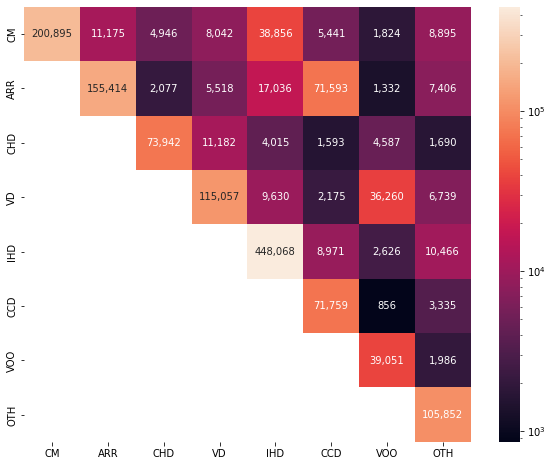

In [13]:
plot_overlap(ctg2pmid)

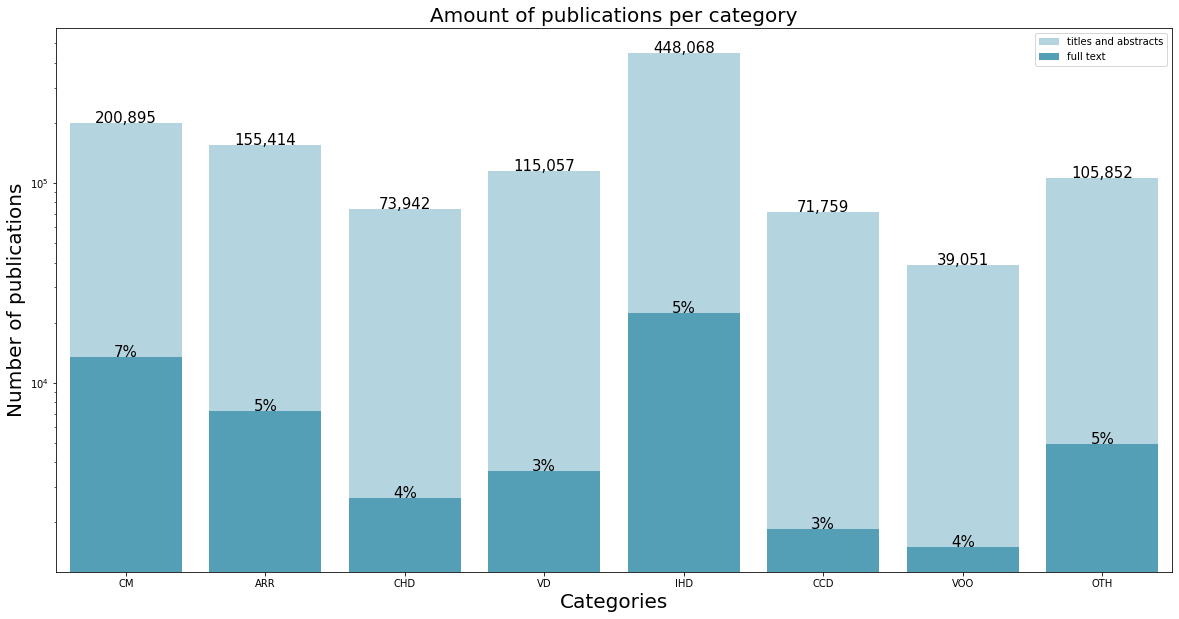

In [105]:
plot_num_of_publications(ctg2pmid, text_ctg2pmid)

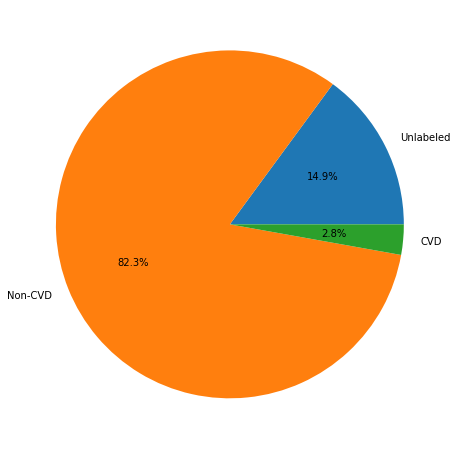

In [358]:
plot_proportion(cate_pmids, uncate_pmids, pmid2cate)

### After

In [284]:
ctg2pmid = update_ctg2pmid(ctg2pmid, pmid2imputed_category)

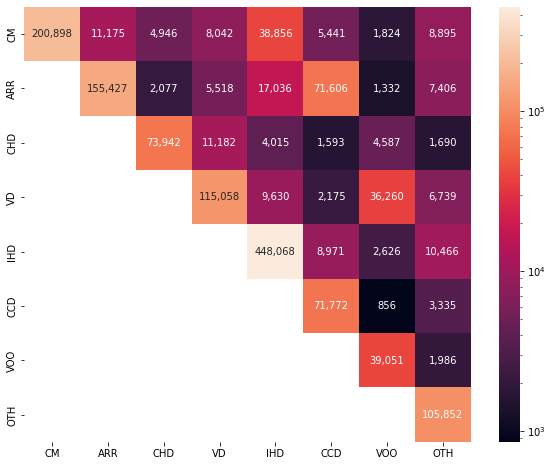

In [347]:
plot_overlap(ctg2pmid)

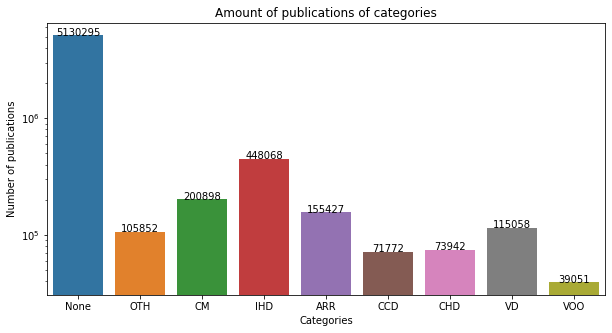

In [286]:
plot_num_of_publications(ctg2pmid)

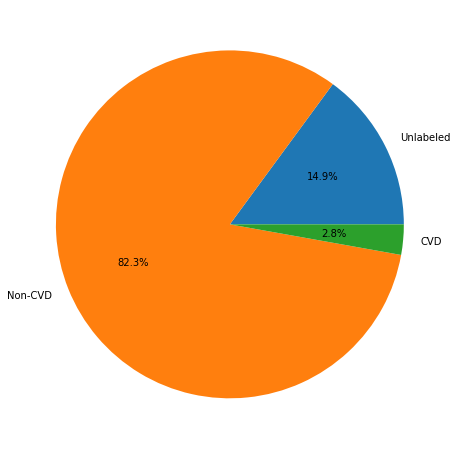

In [351]:
plot_proportion(cate_pmids, uncate_pmids, pmid2cate)

## PMIDs with Full text only

### Before

In [30]:
text_ctg2pmid = generate_ctg2pmid(cate_text_pmids, uncate_text_pmids, pmid2cate)

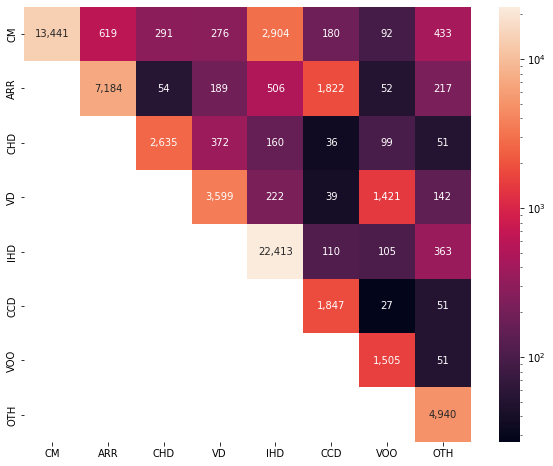

In [352]:
plot_overlap(text_ctg2pmid)

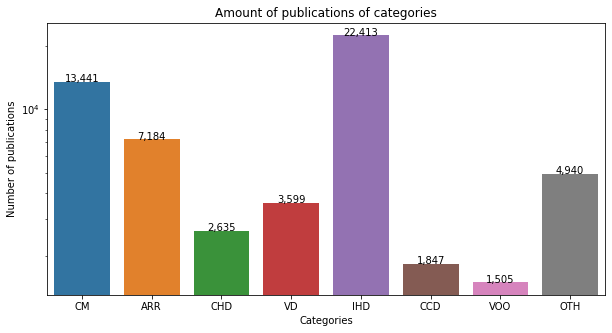

In [359]:
plot_num_of_publications(text_ctg2pmid)

In [354]:
plot_proportion(cate_text_pmids, uncate_text_pmids, pmid2cate)

TypeError: plot_proportion() missing 2 required positional arguments: 'uncat_pmid' and 'pmid2cat'

### After

In [296]:
if run:
    print('Running label imputation')
    '''Undo last label imputation'''
    try:
        pmid2imp_cat_path = os.path.join(mapping_folder,'MeSH/pmid2imputed_category.json')
        pmid2imputed_category = json.load(open(pmid2imp_cat_path))
        try:
            print('Removing the labels imputed last time')
            remove_imputed_category_mesh_terms_previous_li(index_name,
                                                           index_type,
                                                           pmid2imputed_category)
        except:
            raise Exception('Couldnt remove the last indexed imputed labels')
    except:
        print('No previous label imputation')
    '''Get relevant PMIDs'''
    try:
        relevant_pmids = uncate_text_pmids
    except:
        relevant_pmids = get_all_uncategorized_pmids(index_name)
    json.dump(relevant_pmids, open(os.path.join(data_folder,'all_uncategorized_pmids.json'),'w'))

    print(len(relevant_pmids), 'relevant pmids with full text')
        
    ''' Impute missing MeSH labels '''
    # Impute PMIDs' Categories (i.e., Impute missing MeSH labels)
    multiprocess_ds_label_matching(pmids = relevant_pmids, 
                                   index_name = index_name, 
                                   index_type = index_type, 
                                   label_unlabeled_only = True,
                                   label_labeled_only = False,
                                   label_all = False,
                                   filter_list = filter_words,
                                   stop_at_this_many_pmids = STOP_AT_THIS_MANY_PMIDS,
                                   the_function = ds_label_matching,
                                   output_folder = output_folder,
                                   run = True)
    pmid2imputed_category, pmid2imputed_meshsynonym = merge_pmid2new_mesh_labels(run=True,output_folder=output_folder)
    # Index the imputed MeSH categories into their PMID entries
    # index_imputed_mesh_categories(index_name=index_name, index_type=index_type)

Running label imputation
Removing the labels imputed last time
No previous label imputation
1183 relevant pmids with full text
Running jobs...
147 PMIDs processed in one of the batches
147 PMIDs processed in one of the batches
147 PMIDs processed in one of the batches
147 PMIDs processed in one of the batches
147 PMIDs processed in one of the batches
147 PMIDs processed in one of the batches
147 PMIDs processed in one of the batches
146 PMIDs processed in one of the batches
Done!
0 PMIDs with imputed labels


In [297]:
text_ctg2pmid = update_ctg2pmid(text_ctg2pmid, pmid2imputed_category)

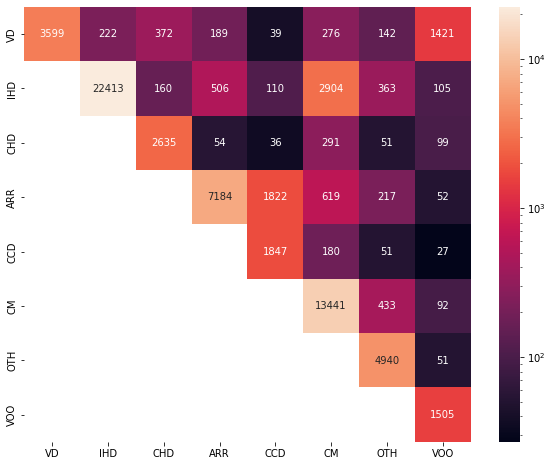

In [298]:
plot_overlap(text_ctg2pmid)

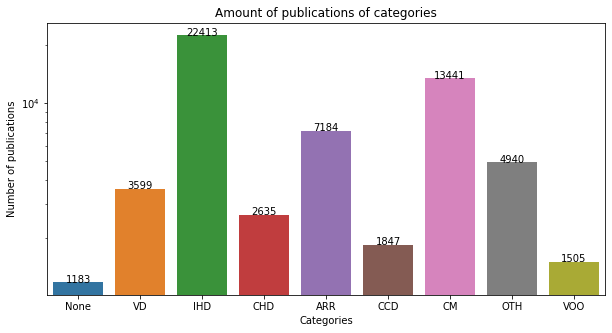

In [299]:
plot_num_of_publications(text_ctg2pmid)

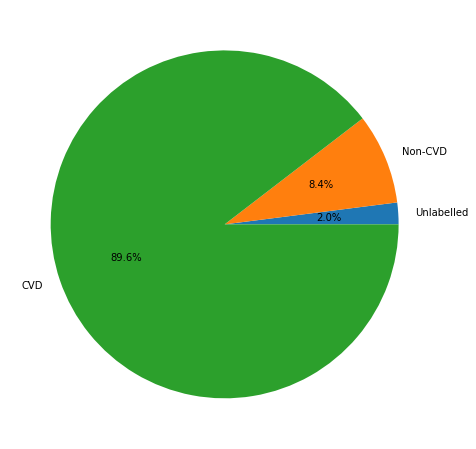

In [300]:
plot_proportion(text_ctg2pmid)